In [21]:
import numpy as np
from tensorflow.keras.layers import Input, SimpleRNN, Dense, concatenate,BatchNormalization,GRU
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score, accuracy_score
from tensorflow.keras.callbacks import Callback
import pandas as pd

In [47]:
from sklearn.preprocessing import StandardScaler
#dynamic preprocessing
dy_train=pd.read_csv('dynamic_train.csv',index_col=0)
max_timesteps = dy_train.groupby('id').size().max()

# the number of features
num_features = len(dy_train.columns) - 2 
# initial an empty array
dy_train = dy_train.sort_values('id')
grouped = dy_train.groupby('id')

data_arrays = []

for _, group in grouped:

    features = group.iloc[:, 2:].values
    
    if len(features) < max_timesteps:
        padding = np.zeros((max_timesteps - len(features), num_features))
        features = np.vstack([features, padding])
    
    data_arrays.append(features)


dy_train_data = np.stack(data_arrays, axis=0)
print(dy_train_data.shape)

(7756, 234, 9)


In [48]:
#dynamic preprocessing
dy_val=pd.read_csv('dynamic_test.csv',index_col=0)
max_timesteps = 234

# the number of features
num_features = len(dy_val.columns) - 2  

# initial an empty array
dy_val = dy_val.sort_values('id')
grouped = dy_val.groupby('id')

data_arrays = []

for _, group in grouped:
    features = group.iloc[:, 2:].values

    if len(features) < max_timesteps:
        padding = np.zeros((max_timesteps - len(features), num_features))
        features = np.vstack([features, padding])
    
    data_arrays.append(features)


dy_val_data = np.stack(data_arrays, axis=0)

print(dy_val_data.shape)

(1940, 234, 9)


In [49]:

scaler = StandardScaler()

for i in range(dy_train_data.shape[2]):
 
    data_reshaped = dy_train_data[:, :, i].reshape(-1, 1)
    data_standardized = scaler.fit_transform(data_reshaped)

    dy_train_data[:, :, i] = data_standardized.reshape(dy_train_data.shape[0], dy_train_data.shape[1])

print(dy_train_data.shape)

(7756, 234, 9)


In [50]:

scaler = StandardScaler()
for i in range(dy_val_data.shape[2]):
    data_reshaped = dy_val_data[:, :, i].reshape(-1, 1)
    data_standardized = scaler.fit_transform(data_reshaped)
    dy_val_data[:, :, i] = data_standardized.reshape(dy_val_data.shape[0], dy_val_data.shape[1])

print(dy_val_data.shape)

(1940, 234, 9)


In [51]:
#static
st_train=pd.read_csv('st_train_pcs.csv',index_col=0)
print(st_train.shape)
st_train = st_train.sort_values('id')
st_train_data=st_train.drop('id',axis=1)
st_train_data=st_train_data.drop('multi_label',axis=1)
print(st_train_data.shape)
st_train_data = scaler.fit_transform(st_train_data)


(7756, 66)
(7756, 64)


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.appl

In [52]:
#static
st_val=pd.read_csv('st_val_pcs.csv',index_col=0)
print(st_val.shape)
st_val = st_val.sort_values('id')
st_val_data=st_val.drop('id',axis=1)
st_val_data=st_val_data.drop('multi_label',axis=1)
print(st_val_data.shape)
st_val_data = scaler.fit_transform(st_val_data)

(1940, 66)
(1940, 64)


D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
D:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.appl

In [80]:
labels=np.array(st_train['multi_label'])
labels

array([1, 2, 1, ..., 1, 1, 2], dtype=int64)

In [81]:
val_label=np.array(st_val['multi_label'])
val_label

array([1, 1, 2, ..., 0, 2, 1], dtype=int64)

In [76]:
dynamic_data = dy_train_data  
static_data = st_train_data 


train_labels = to_categorical(labels, num_classes=3)
val_labels=to_categorical(val_label, num_classes=3)

dynamic_input = Input(shape=(234, 9))
rnn_output = SimpleRNN(32)(dynamic_input)

static_input = Input(shape=(64,))
static_norm=BatchNormalization()(static_input)
dense_output = Dense(32, activation='relu')(static_norm)
#leaky_relu = LeakyReLU(alpha=0.01)(dense_output)

merged_features = concatenate([rnn_output, dense_output])
output = Dense(3, activation='softmax')(merged_features)
model = Model(inputs=[dynamic_input, static_input], outputs=output)

In [82]:
dynamic_data = dy_train_data  
static_data = st_train_data 


train_labels = to_categorical(labels, num_classes=3)
val_labels=to_categorical(val_label, num_classes=3)

dynamic_input = Input(shape=(234, 9))
rnn_output = GRU(32)(dynamic_input)

static_input = Input(shape=(64,))
static_norm=BatchNormalization()(static_input)
dense_output = Dense(32, activation='relu')(static_norm)
#leaky_relu = LeakyReLU(alpha=0.01)(dense_output)

merged_features = concatenate([rnn_output, dense_output])
output = Dense(3, activation='softmax')(merged_features)
model = Model(inputs=[dynamic_input, static_input], outputs=output)

In [83]:
from keras.optimizers import Adamax

model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])


In [78]:
from sklearn.metrics import balanced_accuracy_score
import keras
class MetricsCallback(keras.callbacks.Callback):
    def __init__(self, train_data, validation_data):
        super().__init__()
        self.train_data = train_data
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_preds = self.model.predict(self.validation_data[0], verbose=0)
        val_preds = np.argmax(val_preds, axis=1)  # Convert predictions from one-hot to label encoding
        val_true = np.argmax(self.validation_data[1], axis=1)  # Ensure true labels are also label encoded

        # Calculate balanced accuracy
        val_balanced_accuracy = balanced_accuracy_score(val_true, val_preds)
        print(f"Epoch {epoch + 1}: Validation Balanced Accuracy = {val_balanced_accuracy}")

Epoch 1/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3329 - loss: 1.1791Epoch 1: Validation Balanced Accuracy = 0.3348170595403283
243/243 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.3329 - loss: 1.1790 - val_accuracy: 0.3639 - val_loss: 1.1720
Epoch 2/50
241/243 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3720 - loss: 1.1133Epoch 2: Validation Balanced Accuracy = 0.3593890834594558
243/243 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.3720 - loss: 1.1132 - val_accuracy: 0.3892 - val_loss: 1.1390
Epoch 3/50
241/243 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3936 - loss: 1.0914Epoch 3: Validation Balanced Accuracy = 0.3664922997307541
243/243 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.3937 - loss: 1.0914 - val_accuracy: 0.3928 - val_loss: 1.1349
Epoch 4/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4031 - loss: 1.0833Epoch 4: Validation Balanced Accuracy = 0.3652707574316058
243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.4031 - l

Epoch 26/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4567 - loss: 1.0345Epoch 26: Validation Balanced Accuracy = 0.37125392627901305
243/243 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4567 - loss: 1.0345 - val_accuracy: 0.4000 - val_loss: 1.1261
Epoch 27/50
242/243 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4654 - loss: 1.0303Epoch 27: Validation Balanced Accuracy = 0.36813944105102464
243/243 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.4654 - loss: 1.0304 - val_accuracy: 0.3918 - val_loss: 1.1309
Epoch 28/50
242/243 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4688 - loss: 1.0388Epoch 28: Validation Balanced Accuracy = 0.36799703947637435
243/243 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4688 - loss: 1.0387 - val_accuracy: 0.4041 - val_loss: 1.1295
Epoch 29/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4760 - loss: 1.0294Epoch 29: Validation Balanced Accuracy = 0.3672588085656099
243/243 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accurac

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


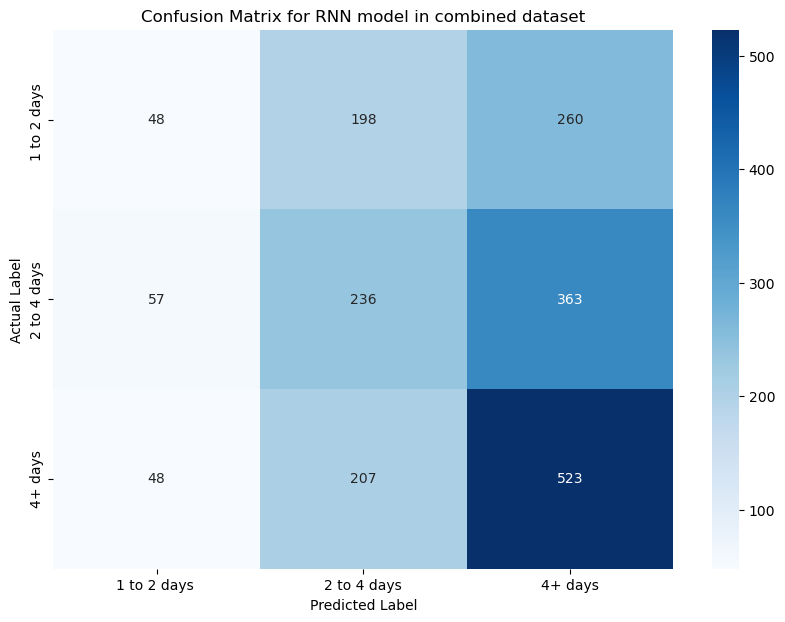

In [79]:
#alive and dead RNN
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

checkpoint_callback = ModelCheckpoint(
    'best_model.keras',  
    monitor='val_loss', 
    save_best_only=True,  
    mode='min'  
)
labels = ['1 to 2 days ', '2 to 4 days', '4+ days'] 
train_data = ([dynamic_data, static_data], train_labels)
val_data = ([dy_val_data, st_val_data], val_labels)
metrics_callback = MetricsCallback(train_data=train_data , validation_data=val_data)

model.fit(
    [dynamic_data, static_data],  # Training data
    train_labels,  # Training labels
    validation_data=([dy_val_data, st_val_data], val_labels),  # Validation data
    epochs=50,  # Number of epochs to train
    batch_size=32,  # Size of the batches of data
    callbacks=[metrics_callback, checkpoint_callback]  # List of callbacks including the ModelCheckpoint
)


from tensorflow.keras.models import load_model
best_model = load_model('best_model.keras')


predictions = best_model.predict([dy_val_data, st_val_data])
predicted_labels = np.argmax(predictions, axis=1)

# Check if val_labels are one-hot encoded and convert if necessary
if val_labels.ndim > 1:  # This checks if val_labels are one-hot encoded
    val_labels = np.argmax(val_labels, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(val_labels, predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix for RNN model in combined dataset')
plt.show()

Epoch 1/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.3601 - loss: 1.1455Epoch 1: Validation Balanced Accuracy = 0.3429411568875131
243/243 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - accuracy: 0.3601 - loss: 1.1454 - val_accuracy: 0.3727 - val_loss: 1.1596
Epoch 2/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3946 - loss: 1.0971Epoch 2: Validation Balanced Accuracy = 0.3529878381279723
243/243 ━━━━━━━━━━━━━━━━━━━━ 24s 101ms/step - accuracy: 0.3946 - loss: 1.0971 - val_accuracy: 0.3897 - val_loss: 1.1419
Epoch 3/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4079 - loss: 1.0883Epoch 3: Validation Balanced Accuracy = 0.35487275254266915
243/243 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step - accuracy: 0.4079 - loss: 1.0882 - val_accuracy: 0.3974 - val_loss: 1.1304
Epoch 4/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4188 - loss: 1.0732Epoch 4: Validation Balanced Accuracy = 0.3565481872761258
243/243 ━━━━━━━━━━━━━━━━━━━━ 26s 106ms/step - accuracy: 0.4

Epoch 26/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.4628 - loss: 1.0367Epoch 26: Validation Balanced Accuracy = 0.3662503755589189
243/243 ━━━━━━━━━━━━━━━━━━━━ 27s 111ms/step - accuracy: 0.4628 - loss: 1.0367 - val_accuracy: 0.4000 - val_loss: 1.1299
Epoch 27/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.4648 - loss: 1.0414Epoch 27: Validation Balanced Accuracy = 0.3728719635901359
243/243 ━━━━━━━━━━━━━━━━━━━━ 42s 115ms/step - accuracy: 0.4648 - loss: 1.0414 - val_accuracy: 0.4072 - val_loss: 1.1337
Epoch 28/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4764 - loss: 1.0340Epoch 28: Validation Balanced Accuracy = 0.3692213956277466
243/243 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step - accuracy: 0.4763 - loss: 1.0340 - val_accuracy: 0.4088 - val_loss: 1.1344
Epoch 29/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.4715 - loss: 1.0363Epoch 29: Validation Balanced Accuracy = 0.37193751682632
243/243 ━━━━━━━━━━━━━━━━━━━━ 26s 109ms/step - accura

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


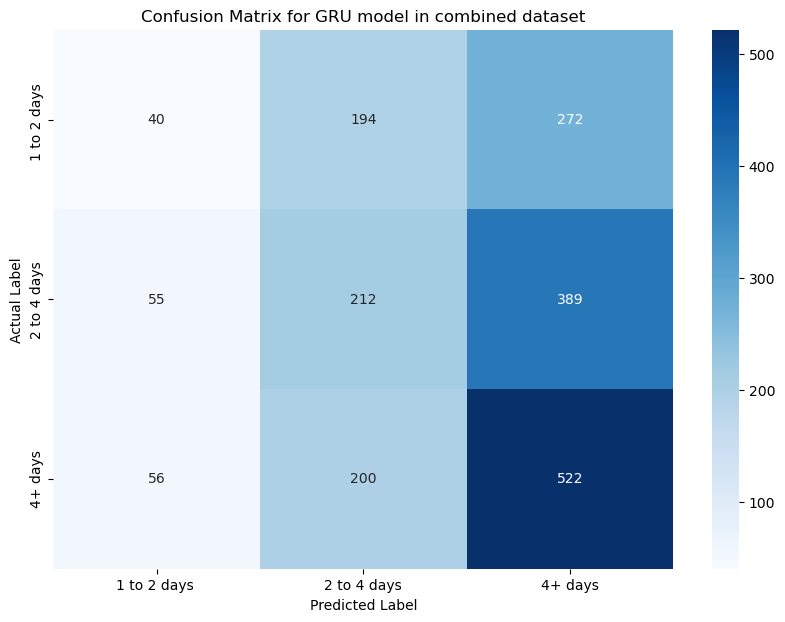

In [84]:
#alive and dead GRU
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

checkpoint_callback = ModelCheckpoint(
    'best_model.keras',  
    monitor='val_loss',  
    save_best_only=True,
    mode='min'  
)
labels = ['1 to 2 days ', '2 to 4 days', '4+ days'] 
train_data = ([dynamic_data, static_data], train_labels)
val_data = ([dy_val_data, st_val_data], val_labels)
metrics_callback = MetricsCallback(train_data=train_data , validation_data=val_data)

model.fit(
    [dynamic_data, static_data],  # Training data
    train_labels,  # Training labels
    validation_data=([dy_val_data, st_val_data], val_labels),  # Validation data
    epochs=50,  # Number of epochs to train
    batch_size=32,  # Size of the batches of data
    callbacks=[metrics_callback, checkpoint_callback]  # List of callbacks including the ModelCheckpoint
)


from tensorflow.keras.models import load_model
best_model = load_model('best_model.keras')


predictions = best_model.predict([dy_val_data, st_val_data])
predicted_labels = np.argmax(predictions, axis=1)

# Check if val_labels are one-hot encoded and convert if necessary
if val_labels.ndim > 1:  # This checks if val_labels are one-hot encoded
    val_labels = np.argmax(val_labels, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(val_labels, predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix for GRU model in combined dataset')
plt.show()